In [2]:
!pip install fastapi


  Using cached fastapi-0.120.1-py3-none-any.whl.metadata (28 kB)
  Using cached starlette-0.48.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached annotated_doc-0.0.3-py3-none-any.whl.metadata (6.6 kB)
Using cached fastapi-0.120.1-py3-none-any.whl (108 kB)
Using cached starlette-0.48.0-py3-none-any.whl (73 kB)
Using cached annotated_doc-0.0.3-py3-none-any.whl (5.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [fastapi]


In [3]:
from envs.wildfire_env import WildfireEnv, WildfireAction

env = WildfireEnv(base_url="http://localhost:8020")
result = env.reset()
print("🔥 Fires:", result.observation.burning_count)
print("💧 Water:", result.observation.remaining_water)

for t in range(3):
    action = WildfireAction(action="wait")
    result = env.step(action)
    print(f"Step {t}: reward={result.reward:.2f}, done={result.done}")
env.close()


🔥 Fires: 2
💧 Water: 8
Step 0: reward=-0.46, done=False
Step 1: reward=-1.06, done=False
Step 2: reward=-1.16, done=False


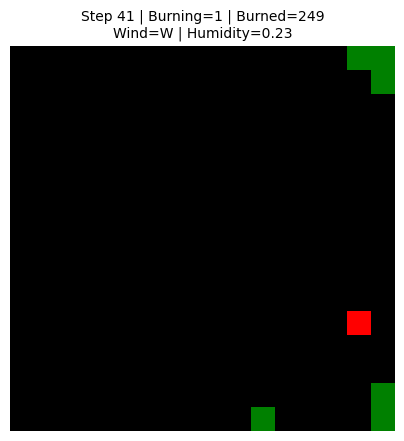

🔥 Fire has fully burned out after 42 steps.
Animation complete.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time, sys
# FIX 1: Import 'display' alongside 'clear_output'
from IPython.display import clear_output, display 
import matplotlib.colors as mcolors
sys.path.append("/workspace/OpenEnv/src")
from envs.wildfire_env import WildfireEnv, WildfireAction # Ensure these imports work

from envs.wildfire_env.server.wildfire_environment import WildfireEnvironment

# Set up client (assuming server is running on 8010)
client = WildfireEnv("http://localhost:8020")

# --- Matplotlib Setup ---
cmap = mcolors.ListedColormap([
    "black",         # 0 = ash
    "green",         # 1 = fuel
    "red",           # 2 = burning
    "saddlebrown",   # 3 = firebreak
    "blue"           # 4 = water
])
# Normalize so integers map cleanly
norm = mcolors.BoundaryNorm([0, 1, 2, 3, 4, 5], cmap.N)

# 1. Initialize Interactive Mode
plt.ion() 
fig, ax = plt.subplots(figsize=(5, 5))
plt.axis("off")

# 2. Get Initial State and Initialize Image Object
res = client.reset()
obs = res.observation
grid = np.array(obs.grid).reshape(obs.height, obs.width)

# Create the image object once
im = ax.imshow(grid, cmap=cmap, norm=norm)

# Create the title object once
title_text = ax.set_title(
    f"Step {obs.step} | Burning={obs.burning_count} | Burned={obs.burned_count}\n"
    f"Wind={obs.wind_dir} | Humidity={obs.humidity:.2f}",
    color="black", 
    fontsize=10
)

# NOTE: The initial clear_output and display(fig) calls are removed here.

print("Starting smooth animation...")

# --- Animation Loop (Updating In Place and Forcing Display) ---
for _ in range(100): 
    # 1. Clear previous output
    clear_output(wait=True) 
    
    # Get the new grid data
    new_grid = np.array(obs.grid).reshape(obs.height, obs.width)

    # 2. Update the Image Data 
    im.set_data(new_grid)

    # 3. Update the Title Text
    title_text.set_text(
        f"Step {obs.step} | Burning={obs.burning_count} | Burned={obs.burned_count}\n"
        f"Wind={obs.wind_dir} | Humidity={obs.humidity:.2f}"
    )

    # 4. Display the updated figure (FORCES redraw in non-interactive environments)
    display(fig) 
    
    # Control the speed (slightly increased for visibility)
    time.sleep(0.3) 

    # Advance the simulation
    res = client.step(WildfireAction(action="WAIT"))
    obs = res.observation

    # Stop condition
    if obs.burning_count == 0:
        print(f"🔥 Fire has fully burned out after {obs.step} steps.")
        break

plt.ioff() # Turn off interactive mode
plt.close(fig) # Close the figure at the end
print("Animation complete.")
